# HW_8

In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [53]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [54]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [55]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(784, 128, name="dense_layer_1")
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(128, 256, name="dense_layer_2")
        # Вихідний шар
        self.output_layer = DenseLayer(256, 10, name="output_layer")

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = tf.reshape(x, (tf.shape(x)[0], -1))  # Розгортаємо вхідні дані
        x = self.layer1(x)
        x = self.layer2(x)
        return self.output_layer(x)

In [56]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    acc = accuracy_score(y_true, y_pred_labels)
    return acc

In [57]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [58]:
# Тренування мережі
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Обчислення поточної втрати
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss.numpy())

        # Обчислення поточної точності
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)

        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")

Step 100, Loss: 2.2381699085235596, Accuracy: 0.109375
Step 200, Loss: 0.1670655906200409, Accuracy: 0.10546875
Step 300, Loss: 0.07925830036401749, Accuracy: 0.08984375
Step 400, Loss: 0.1896372139453888, Accuracy: 0.1015625
Step 500, Loss: 0.07993568480014801, Accuracy: 0.109375
Step 600, Loss: 0.07409995049238205, Accuracy: 0.07421875
Step 700, Loss: 0.05779223144054413, Accuracy: 0.08984375
Step 800, Loss: 0.016934741288423538, Accuracy: 0.109375
Step 900, Loss: 0.033728279173374176, Accuracy: 0.12890625
Step 1000, Loss: 0.01392791885882616, Accuracy: 0.09765625
Step 1100, Loss: 0.020959123969078064, Accuracy: 0.1015625
Step 1200, Loss: 0.007705308496952057, Accuracy: 0.07421875
Step 1300, Loss: 0.054740969091653824, Accuracy: 0.078125
Step 1400, Loss: 0.00929822027683258, Accuracy: 0.1015625
Step 1500, Loss: 0.08099281042814255, Accuracy: 0.12890625
Step 1600, Loss: 0.02214617282152176, Accuracy: 0.06640625
Step 1700, Loss: 0.012243402190506458, Accuracy: 0.1015625
Step 1800, Loss

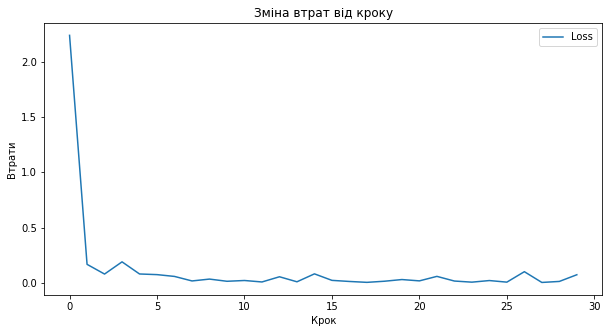

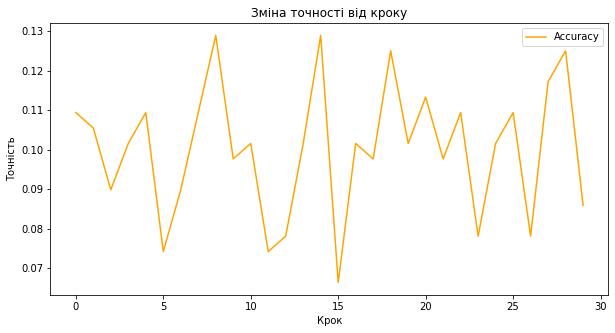

In [59]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіку функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Loss')
plt.title('Зміна втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# Виведення графіку точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.legend()
plt.show()

In [60]:
# Обчислення точності навченої нейромережі
test_accuracy = accuracy(neural_net(x_test), y_test)
print(f"Точність на тестових даних: {test_accuracy}")

# Тестування моделі на тестових даних
test_loss = cross_entropy(neural_net(x_test), y_test)
print(f"Втрати на тестових даних: {test_loss}")

Точність на тестових даних: 0.0924
Втрати на тестових даних: 0.9633118510246277


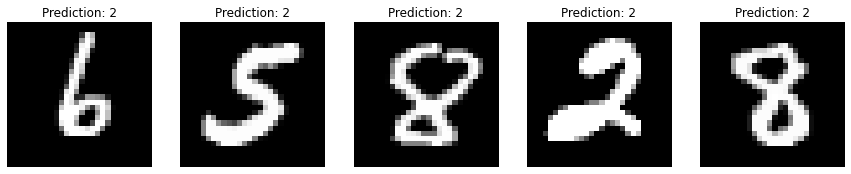

In [61]:
# Випадкові індекси для вибору 5 зображень
random_indices = np.random.choice(len(x_test), size=5, replace=False)

# Обрізка та масштабування зображень до 0-1 діапазону
test_images = x_test[random_indices]
test_images = test_images / 255.0

# Передача зображень у нейромережу та отримання передбачень
predictions = neural_net(test_images)

# Виведення зображень та відповідних передбачень
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Prediction: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()

In [62]:
'''Висновки:

1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, 
оскільки більшість передбачень вірно збігаються з фактичними мітками. 
Однак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.

2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. 
Наприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.
'''

'Висновки:\n\n1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, \nоскільки більшість передбачень вірно збігаються з фактичними мітками. \nОднак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.\n\n2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. \nНаприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.\n'